### Author: Pratham Dedhiya (pdedhiya)

### DvXray YOLOv8 Training Pipeline

**Project:** Multi-View Detection of Prohibited Items in X-ray Images  
**Model:** YOLOv8 (Nano)  
**Dataset:** DvXray (Processed)

This notebook trains a YOLOv8 object detection model using the dataset generated in the preprocessing step. 

**Steps:**
1. Setup Environment (Ultralytics)
2. Initialize Model (YOLOv8)
3. Train Model
4. Evaluate & Visualize Results

#### 1. Setup Environment

In [5]:
# Install Ultralytics YOLOv8
#!pip install ultralytics

In [6]:
import os
import torch
from ultralytics import YOLO
from IPython.display import Image, display
import random
import glob

# Check for GPU
print(f"Setup complete. Using torch {torch.__version__} ({'GPU' if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 2.9.1+cu130 (GPU)


#### 2. Initialize Model
Currently using **YOLOv8 Nano (`yolov8n.pt`)**. 
This is the smallest and fastest model, fitting the "lightweight real-time models" extension mentioned in our proposal. 

In [ ]:
# Load a pretrained YOLOv8n model
model = YOLO("yolov8n.pt")  

#### 3. Train Model

**Configuration for Imbalance Handling:**
- `epochs=50`: A solid baseline. Increase to 100+ for final results.
- `imgsz=640`: Standard YOLO resolution.
- `cos_lr=True`: Cosine learning rate scheduler helps converge better on difficult datasets.
- `optimizer='auto'`: YOLOv8 defaults to SGD or AdamW depending on dataset size.
- **Class Imbalance:** YOLOv8 automatically uses **Focal Loss** for object detection, which up-weights hard-to-classify examples (rare items) and down-weights easy backgrounds.

In [8]:
results = model.train(
    data="dvxray.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    name="dvxray_yolo_run",
    device=0,      # Set to 0 for GPU, 'cpu' for CPU
    cos_lr=True,   # Helps with convergence
    patience=10,   # Stop early if no improvement for 10 epochs
    plots=True,     # Save plots (confusion matrix, labels, etc.)
    workers=0,
    resume=True,
)

New https://pypi.org/project/ultralytics/8.3.234 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.233  Python-3.13.7 torch-2.9.1+cu130 CUDA:0 (NVIDIA GeForce RTX 5070 Laptop GPU, 8151MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=dvxray.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=dvxray_yolo_run2, nbs=64, nms=False

#### 4. Evaluation & Visualization

In [17]:
# Validate the model on the validation set to get final metrics
model = YOLO("runs/detect/dvxray_yolo_run/weights/best.pt")
metrics = model.val()

print(f"mAP@50-95: {metrics.box.map}")
print(f"mAP@50:    {metrics.box.map50}")

Ultralytics 8.3.233  Python-3.13.7 torch-2.9.1+cu130 CUDA:0 (NVIDIA GeForce RTX 5070 Laptop GPU, 8151MiB)
Model summary (fused): 72 layers, 3,008,573 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1816.11085.6 MB/s, size: 227.1 KB)
val: Scanning D:\Desktop\Pratham\IUB\SEM 3\ENGR-E 533 Deep Learning Systems\Project\Deep-Learning-Final-Project\data\processed\yolo\labels\val.cache... 6400 images, 4449 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 6400/6400 6.8Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 400/400 17.6it/s 22.8s<0.1s
                   all       6400       2177      0.878      0.775      0.848      0.682
                   Gun        130        132      0.814      0.947      0.965      0.847
                 Knife        158        158      0.743      0.576      0.692      0.495
                Wrench        142        144      0.893      0.896      0.953      0.831
   

##### 4.1 Visualization: Confusion Matrix
This helps check if the model is biased against rare classes (e.g., Darts vs Guns).

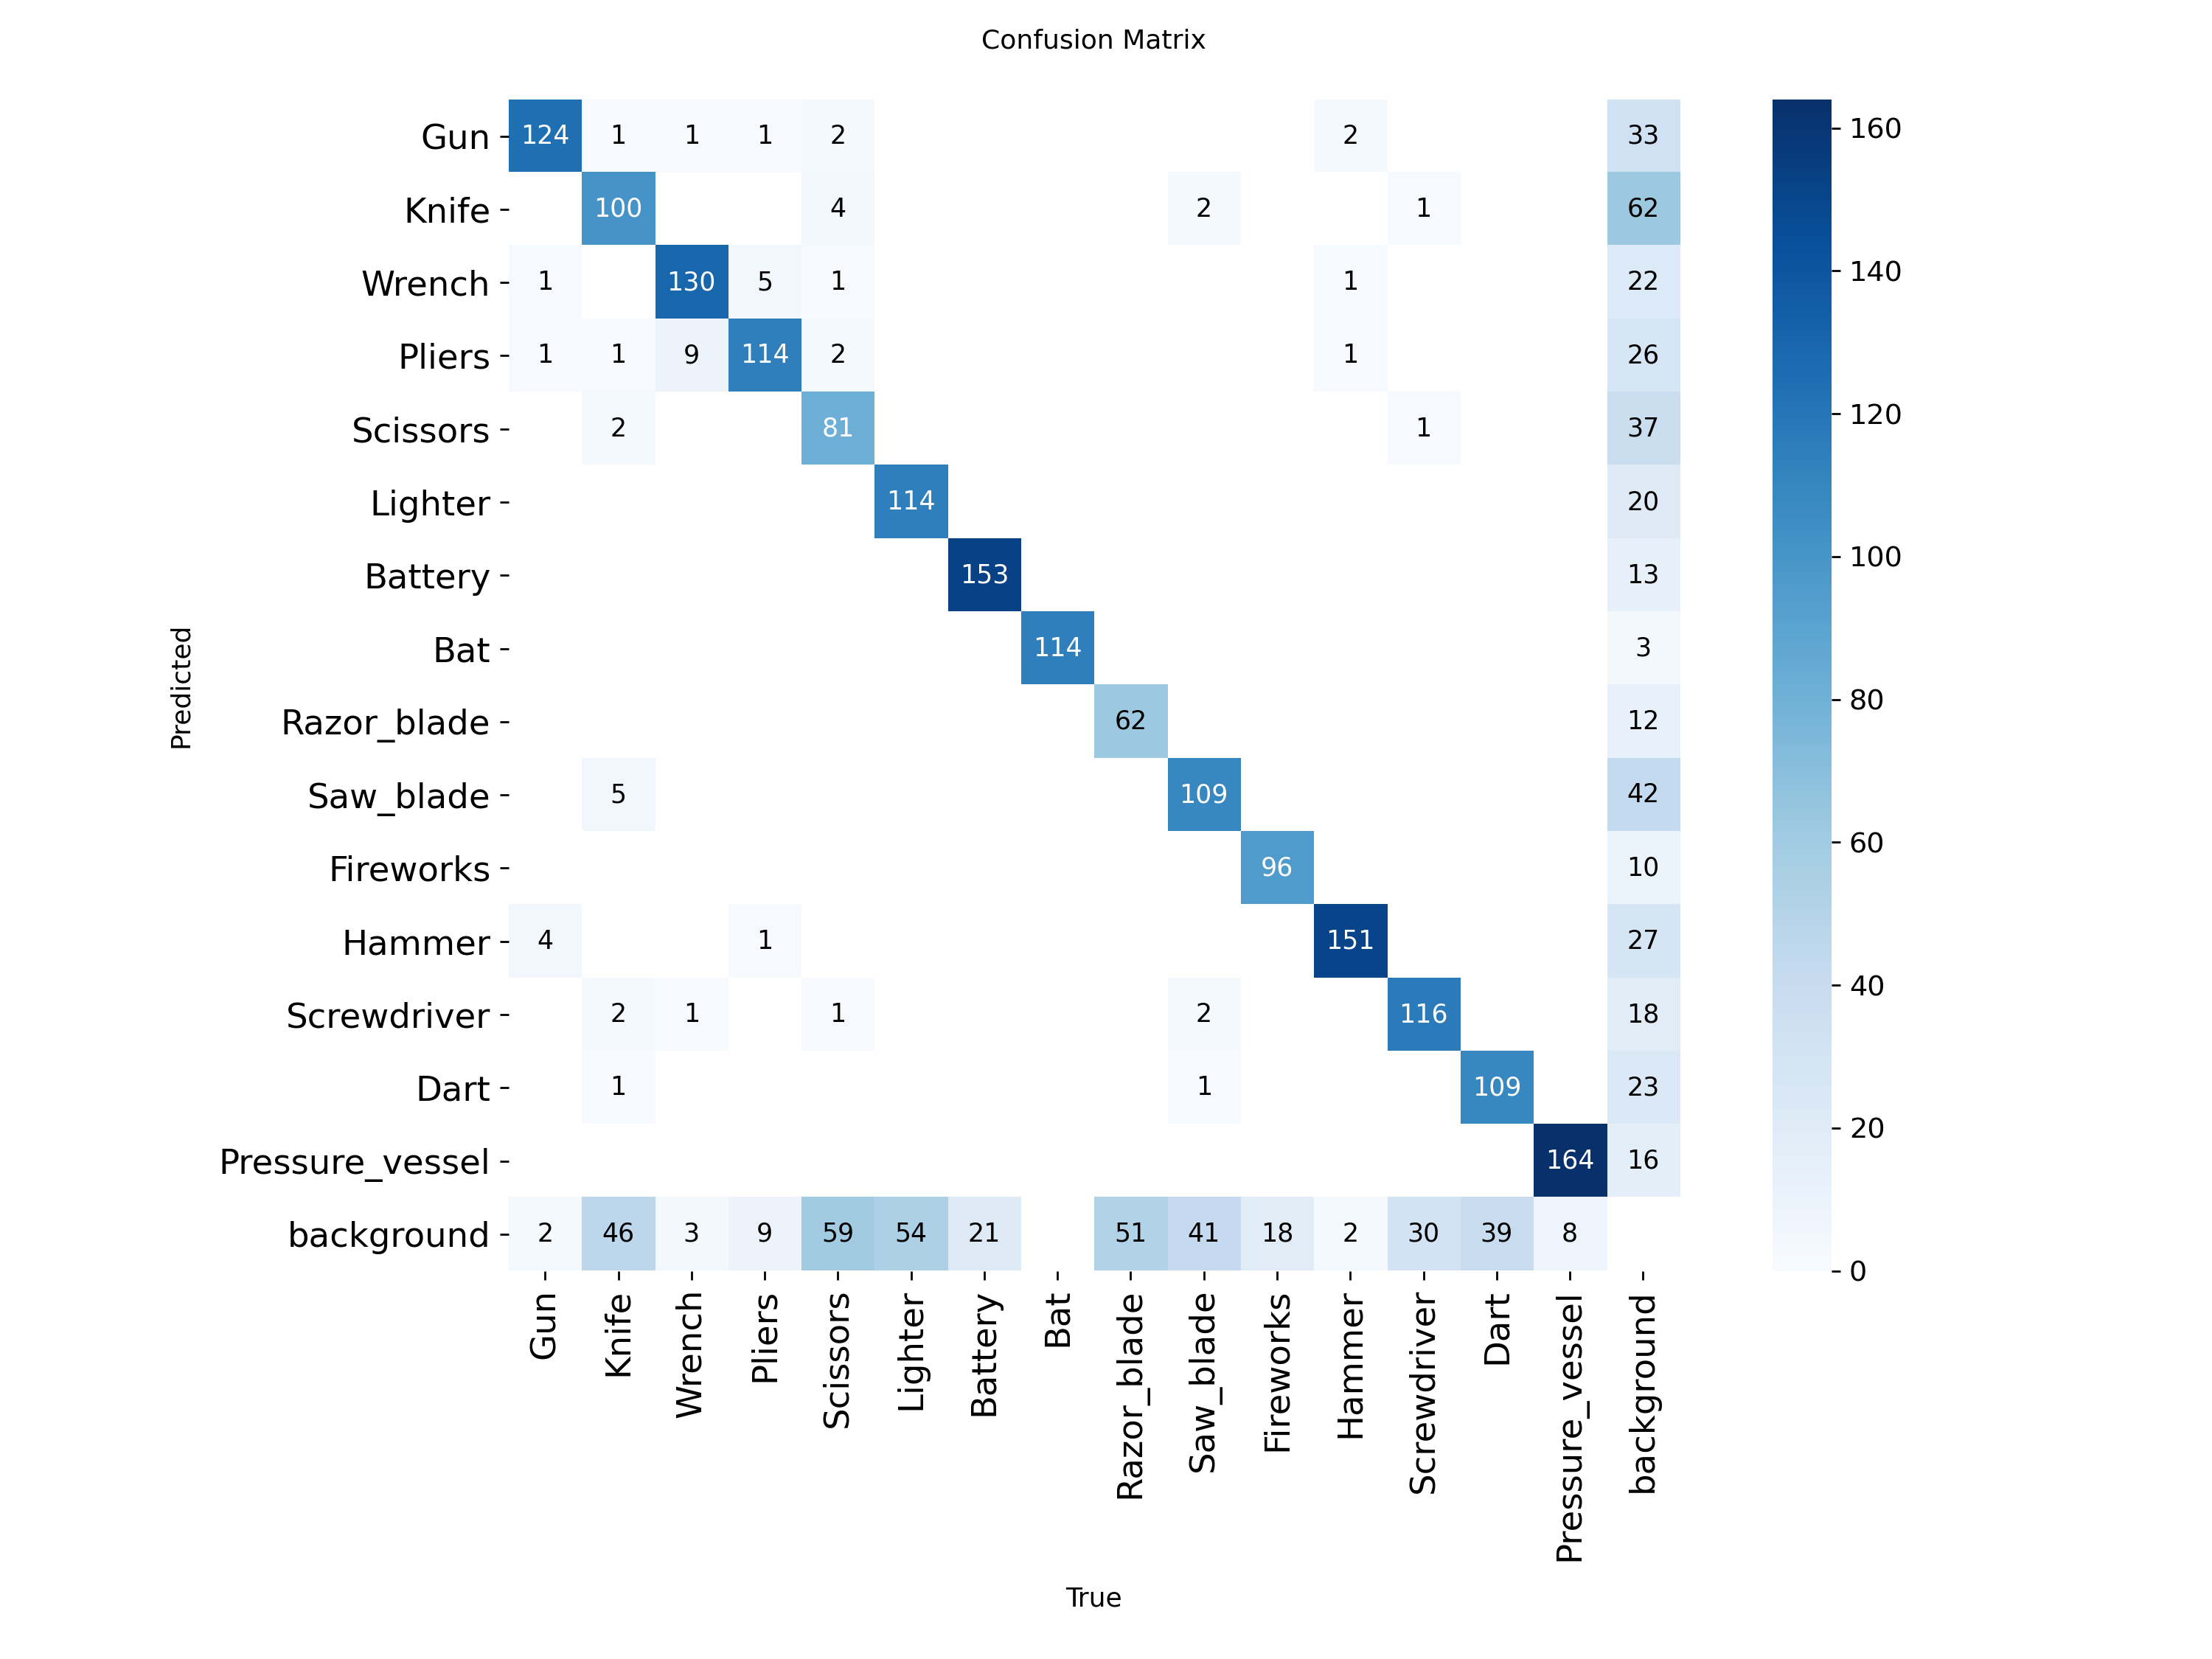

In [13]:
# Display Confusion Matrix from the training run
# Note: The path might vary slightly depending on the OS, checking typical location
cm_path = "runs/detect/dvxray_yolo_run/confusion_matrix.png"

if os.path.exists(cm_path):
    display(Image(filename=cm_path, width=600))
else:
    print("Confusion matrix not found yet (training might have failed or is incomplete).")

##### 4.2 Visualization: Sample Predictions
A batch of validation predictions.

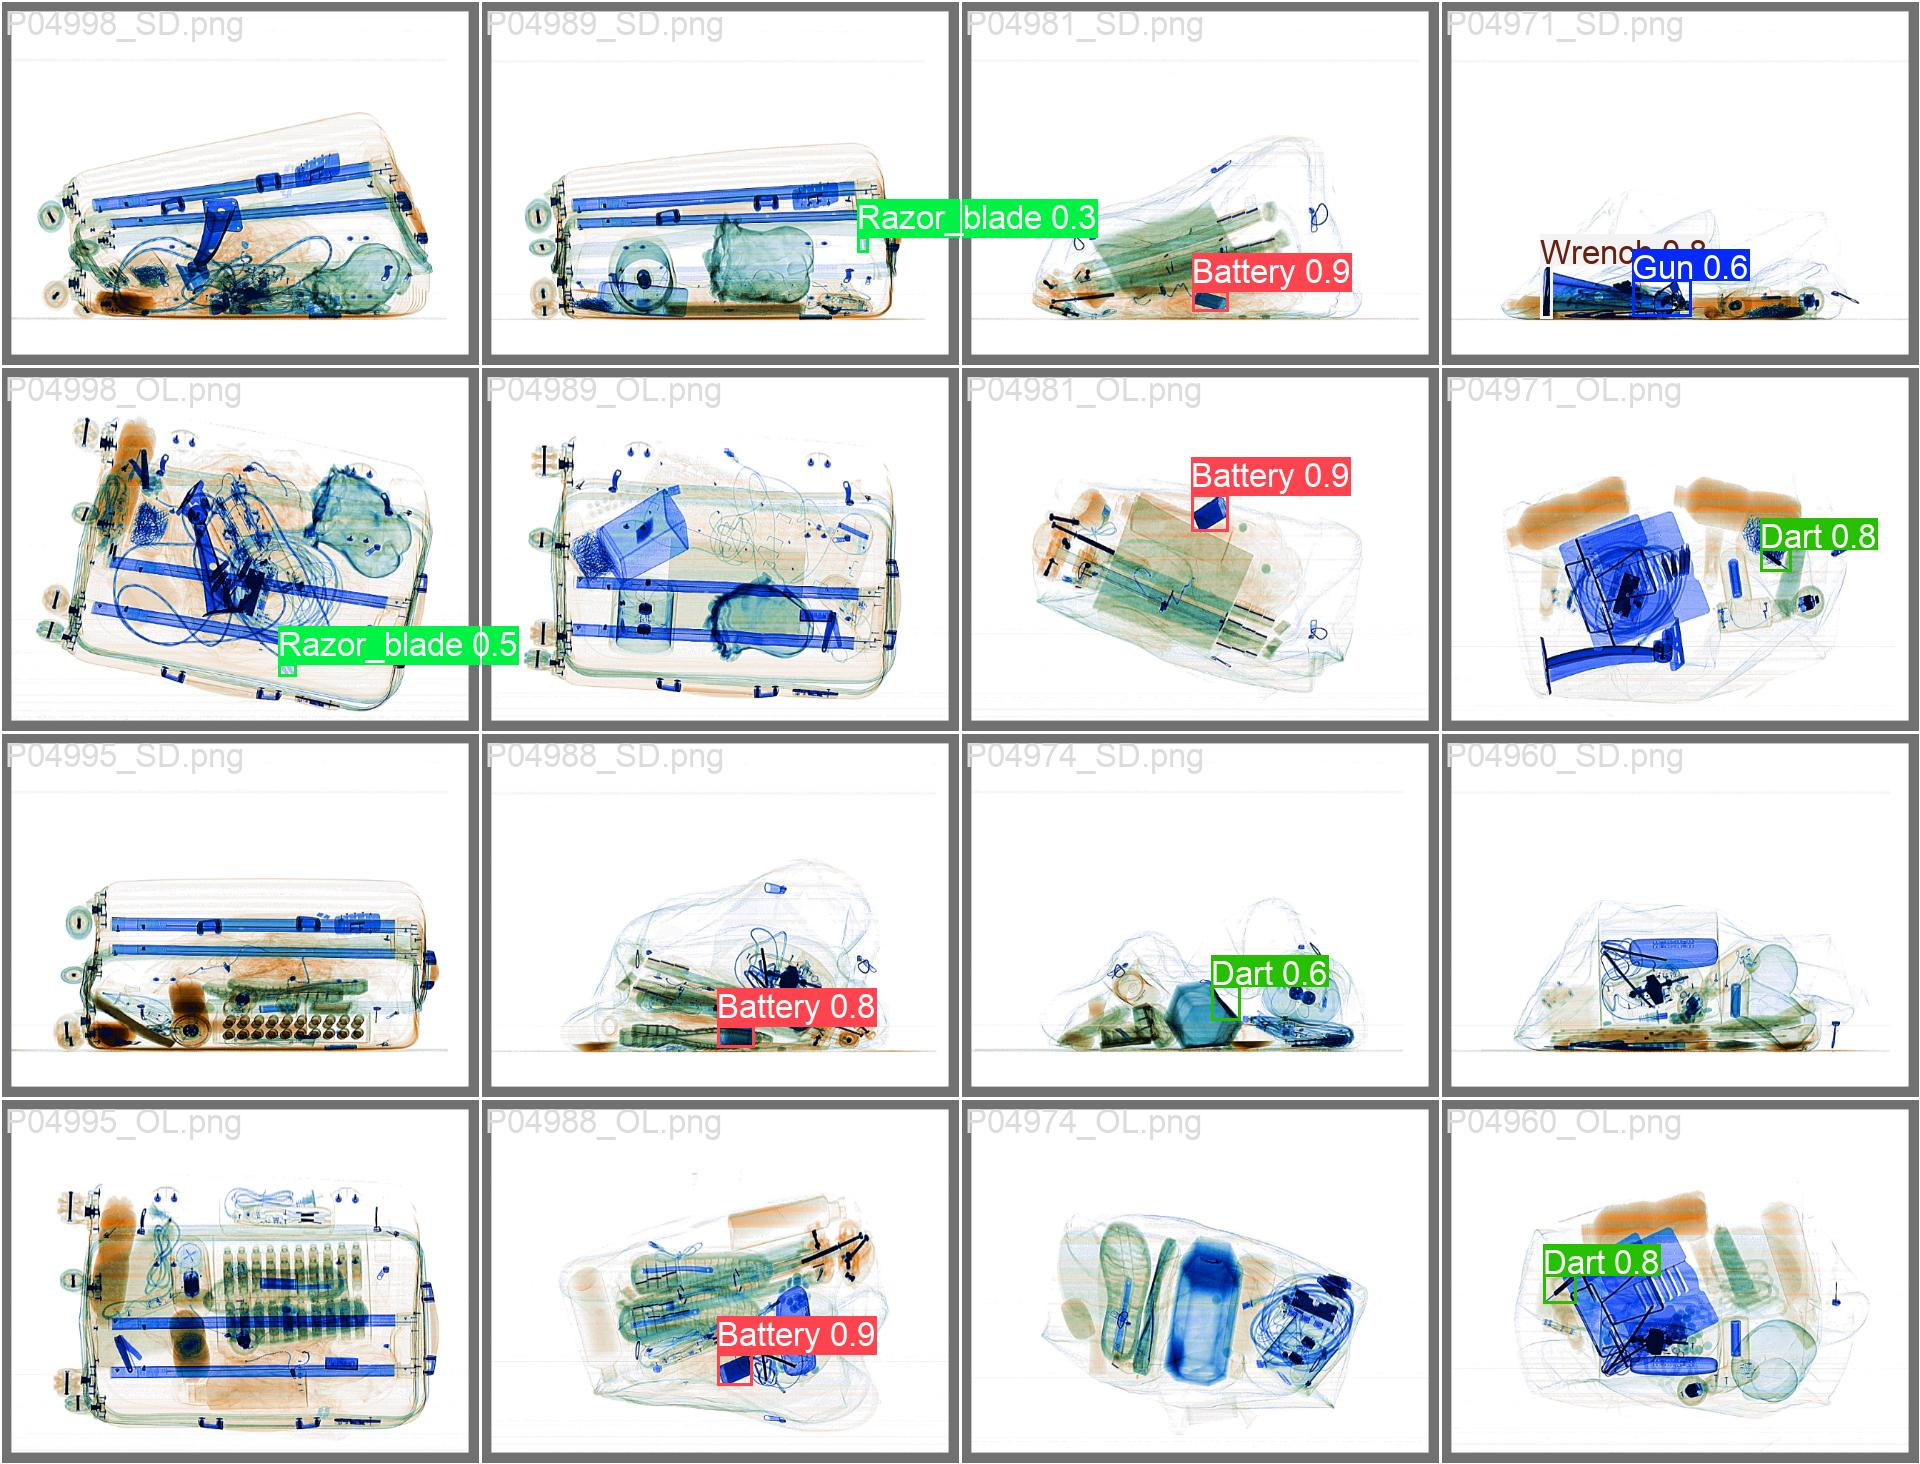

In [14]:
# Display a batch of validation predictions
val_pred_path = "runs/detect/dvxray_yolo_run/val_batch0_pred.jpg"

if os.path.exists(val_pred_path):
    display(Image(filename=val_pred_path, width=800))
else:
    print("Validation prediction batch not found.")

#### 5. Inference Test
Run the model on a single random image from the validation set.

In [15]:
# Pick a random image from the validation set
val_images = glob.glob("../../data/processed/yolo/images/val/*.png")
if val_images:
    test_img = random.choice(val_images)
    print(f"Testing on: {test_img}")

    # Run inference
    results = model.predict(test_img)

    # Show result
    for r in results:
        im_array = r.plot()  # plot a BGR numpy array of predictions
        import cv2
        import matplotlib.pyplot as plt
        
        # Convert BGR to RGB for matplotlib
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
else:
    print("No validation images found to test.")

Testing on: ../../data/processed/yolo/images/val\N01635_SD.png



image 1/1 d:\Desktop\Pratham\IUB\SEM 3\ENGR-E 533 Deep Learning Systems\Project\Deep-Learning-Final-Project\models\yolo\..\..\data\processed\yolo\images\val\N01635_SD.png: 480x640 (no detections), 54.0ms
Speed: 3.4ms preprocess, 54.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


<Figure size 1000x1000 with 1 Axes>